In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

# PMF from US-WHAM

The reaction coordinate for this calculation is the central torsion of the motor. The full rotation is stratified into 61 windows from -180.0 to 180.0 degrees with a spring constant of 0.07 kcal/mol/deg$^2$ (or $\sim$230 kcal/mol/rad$^2$). The potential of mean force (PMF) is generated using the WHAM code from the Grossfeld Lab. The command line argument I used is

`wham -P -180.0 180.0 101 1e-6 300.0 0 meta PMFumb.dat`

The plot below shows the PMF of 1 ns blocks and we can see that the PMF converges after 3 ns. From 4 to 10 ns the PMF fluctuates around an equilibrium line. Extra US windows were included to ensure a 25% overlap between adjacent windows (see histogram plot below).

In [3]:
# Get file names
iterations = 20

meta = []
for i in range(iterations):
    if i < 9:
        meta.append(f'wham/meta-0{i+1}')
    else:
        meta.append(f'wham/meta-{i+1}')

trajs = []
for i in range(iterations):
    temp = []
    centers = []
    for line in open(meta[i]):
        if not line.startswith("#"):
            temp.append(line.split()[0].split('../')[-1])
            centers.append(float(line.split()[1])*np.pi/180)
    trajs.append(temp)
windows = len(trajs[0])
centers = np.array(centers)

In [4]:
# Collect data
traj = np.zeros((windows, len(np.loadtxt(trajs[0][0]))*iterations), dtype=np.float64)
print(f'Shape of data {traj.shape}')
for i in range(iterations):
    for j in range(windows):
        temp = np.loadtxt(trajs[i][j])[:,1]

        if j in [0,1,2]:
            temp[temp>0] -= 360

        if j in [windows-1,windows-2,windows-3]:
            temp[temp<0] += 360

        n = len(temp)
        traj[j, n*i:n*(i+1)] = temp*np.pi/180

Shape of data (66, 20020)


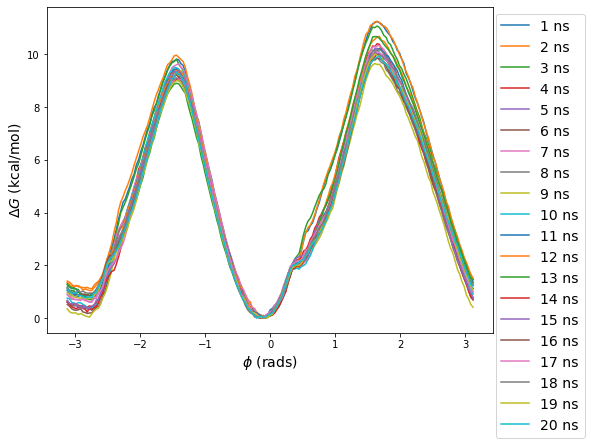

In [5]:
plt.figure(figsize=(8,6))
PMF = []
for i in range(iterations):
    if i < 9:
        temp = np.loadtxt(f'wham/PMF-0{i+1}.dat')
    else:
        temp = np.loadtxt(f'wham/PMF-{i+1}.dat')
    PMF.append(temp[:,1])
    plt.plot(temp[:,0]*np.pi/180, temp[:,1], label=f'{i+1} ns')

phi_G = temp[:,0]*np.pi/180
PMF = np.array(PMF)

plt.xlabel('$\phi$ (rads)', fontsize=14)
plt.ylabel('$\Delta G$ (kcal/mol)', fontsize=14)
plt.legend(loc=1, bbox_to_anchor=(1.22, 1.0), fontsize=14)

### Histogram of US windows

Text(0, 0.5, 'count')

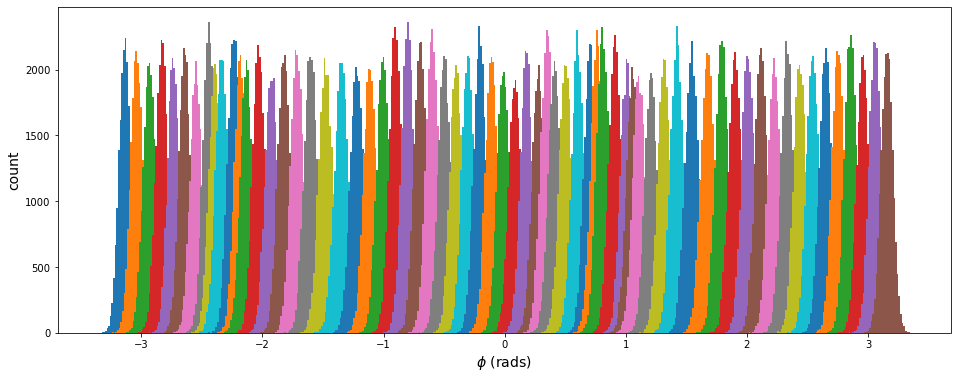

In [7]:
# Plot histograms
nbins = 30

plt.figure(figsize=(16,6))
for i in range(windows):
    plt.hist(traj[i,:], bins=nbins, density=False)
    
plt.xlabel('$\phi$ (rads)', fontsize=14)
plt.ylabel('count', fontsize=14)

### Numerical estimate of the overlap between adjacent windows

In [17]:
def return_intersection(hist1, hist2):
    minima = np.minimum(hist1, hist2)
    intersect_1 = np.true_divide(np.sum(minima), np.sum(hist1))
    intersect_2 = np.true_divide(np.sum(minima), np.sum(hist2))
    return np.array([intersect_1, intersect_2])

tolerance = 0.25
overlap = np.zeros((windows-1,2))

for j in range(windows-1):
    min_x = np.min(traj[j,:])
    max_x = np.max(traj[j,:])
    hist1, _ = np.histogram(traj[j,:],   bins=nbins, range=[min_x, max_x])
    hist2, _ = np.histogram(traj[j+1,:], bins=nbins, range=[min_x, max_x])
    overlap[j,:] = return_intersection(hist1, hist2)
    if overlap[j,0] < tolerance:
        print(f'{j+1}\t{j+2}\t{overlap[j,0]:.2f} *\t{centers[j]*180/np.pi:7.2f} | {centers[j+1]*180/np.pi:7.2f} {trajs[0][j]} | {trajs[0][j+1]}')
    else:
        print(f'{j+1}\t{j+2}\t{overlap[j,0]:.2f}  \t{centers[j]*180/np.pi:7.2f} | {centers[j+1]*180/np.pi:7.2f} {trajs[0][j]} | {trajs[0][j+1]}')

1	2	0.33  	-180.00 | -174.00 main/out_umb01-01.colvars.traj | main/out_umb02-01.colvars.traj
2	3	0.31  	-174.00 | -168.00 main/out_umb02-01.colvars.traj | main/out_umb03-01.colvars.traj
3	4	0.31  	-168.00 | -162.00 main/out_umb03-01.colvars.traj | main/out_umb04-01.colvars.traj
4	5	0.33  	-162.00 | -156.00 main/out_umb04-01.colvars.traj | main/out_umb05-01.colvars.traj
5	6	0.34  	-156.00 | -150.00 main/out_umb05-01.colvars.traj | main/out_umb06-01.colvars.traj
6	7	0.34  	-150.00 | -144.00 main/out_umb06-01.colvars.traj | main/out_umb07-01.colvars.traj
7	8	0.28  	-144.00 | -138.00 main/out_umb07-01.colvars.traj | main/out_umb08-01.colvars.traj
8	9	0.63  	-138.00 | -135.00 main/out_umb08-01.colvars.traj | extra/out_umb08-01.colvars.traj
9	10	0.59  	-135.00 | -132.00 extra/out_umb08-01.colvars.traj | main/out_umb09-01.colvars.traj
10	11	0.33  	-132.00 | -126.00 main/out_umb09-01.colvars.traj | main/out_umb10-01.colvars.traj
11	12	0.59  	-126.00 | -123.00 main/out_umb10-01.colvars.traj | e

# Position-dependent diffusivity

The output from umbrella sampling (US) calculations can be used to estimate the diffusion coefficient along the reaction coordinate $\phi$. The expression below is valid for a system behaving as an overdamped harmonic oscillator (i.e. the harmonic restraint applied at each US window must be strong enough to enforce this behaviour).

$$\large D(\phi) \approx \frac{\text{var}(\phi)}{\tau}$$

Here, $\tau$ is the decay constant (or correlation time) of the autocorrelation of the reaction coordinate 
$$\large \tau = \frac{\int_{0}^{\infty} \langle \phi(t)\phi(0) \rangle dt}{\text{var}(\phi)}$$

and $\text{var}(\phi)$ is the variance of the reaction coordinate in each US window.

One problem with estimating the decay constant with autocorrelation is that it is highly sensitive to the quality of the data. Instead, we can get around this limitation using the approximation below
$$\large \tau \approx \left[\frac{n_{\text{data}}\text{var}(\bar{\phi})}{\text{var}(\phi)} - 1 \right]\times \frac{\Delta t}{2}$$
The expression above is determined using block-data averaging method. If $n_{\text{data}}$ is the number of samples in each blocks then $\bar{\phi}$ is the average reaction coordinate at each block and $\text{var}(\bar{\phi})$ is the variance of the block averages. $\text{var}(\phi)$ is the variance of the whole data (without block-averaging) and $\Delta t$ is the time between each frame (output frequency from MD software multiplied by the integrator time-step). I have found that a block average of 50 gives good results.

As discussed in Ref, the estimate of local diffusion coefficients is associated with large fluctuations. Therefore, to get a smoother profile I performed a moving average at each window $i$ over 11 windows (i.e. from $i-5$ to $i+5$). Since the PMF is treated periodically in WHAM I also treated the smoothing of the windows near the boundaries ($-\pi$ and $\pi$) periodically.

In [11]:
# Load the data
data_full = np.load('diffusion/0.07kcal/full_data.npy')

# Determine the shape of the data
windows, nSamples = np.shape(data_full)

In [12]:
dt = 2.0

split_data = 4
move_ave = 5

nblocks = [10,20,50,100]

phi_D = np.linspace(-np.pi,np.pi,windows)
split_samples = int(nSamples/split_data)

var  = np.zeros((split_data,windows), dtype=np.float64)
tau  = np.zeros((split_data,len(nblocks),windows), dtype=np.float64)
diff = np.zeros((split_data,len(nblocks),windows), dtype=np.float64)
moving_diff = np.zeros(windows, dtype=np.float64)

# Loop over 1ns block
for s in range(split_data):
    i = s*split_samples
    j = (s+1)*split_samples
    data = data_full[:,i:j] #<--- Get current 1ns block
    
    # Loop over windows
    for w in range(windows):
        # Calculate the variance
        var[s,w] = np.var(data[w])
        
        # Loop over blocks
        for nb in range(len(nblocks)):
            # Number of samples in a block
            ndata = int(split_samples / nblocks[nb])
            
            # Loop over data in blocks
            ave_z = []
            for n in range(nblocks[nb]):
                i = n*ndata
                j = (n+1)*ndata
                ave_z.append(np.mean(data[w,i:j]))

            # Estimate the decay constant
            tau[s,nb,w] = (np.var(ave_z)*ndata/var[s,w] - 1)*dt/2
            
            # Estimate the diffusivity (rad^2/ns)
            diff[s,nb,w] = var[s,w]/tau[s,nb,w]*1e6  #<--- I multiplied this by 1e6 so that the results are 
                                                     #     in rad^2/ns instead of rad^2/fs

# Average over the four 1ns blocks
ave_diff = np.mean(diff, axis=0)

# Moving average (smoothing)
for i in range(windows):
    index = np.arange(i-move_ave, i+move_ave+1, 1)   #<--- averaging windows
    index[index>windows-1] -= windows                #<--- fix periodicity
    moving_diff[i] = np.mean(ave_diff[2,index])      #<--- I chose a block of 50 because the resutls are stable
                                                     #     feel free to play around and see how the diffusion
                                                     #     profile change with different blocks

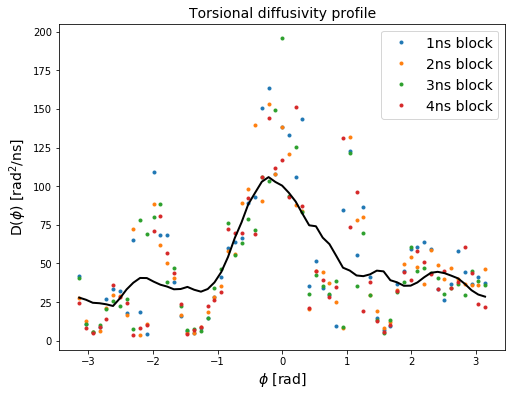

In [13]:
# Plot Results
plt.figure(figsize=(8,6))
for i in range(split_data):
    plt.plot(phi_D,diff[i,2,:],'.',label=f'{i+1}ns block')
plt.plot(phi_D, moving_diff, '-k', linewidth=2.0)

plt.xlabel('$\phi$ [rad]', fontsize=14)
plt.ylabel(f'D($\phi$) [rad$^2$/ns]', fontsize=14)
plt.title('Torsional diffusivity profile', fontsize=14)
plt.legend(fontsize=14)

## Mean-first passage time and rate constant

Given the PMF $\Delta G(\phi)$ and the position-dependent diffusivity $D(\phi)$ we can estimate the mean-first passage time (MFPT) using the Smoluchowski equation in the high friction limit:

$$\large t_{a\rightarrow b} = \int^{b}_{a} d\phi \frac{\text{exp}[\beta \Delta G(\phi)]}{D(\phi)} \times \int^{\phi}_{a}d\phi^{\prime} \text{exp}[-\beta \Delta G(\phi^{\prime})]$$

The rate constant for the torsion angle $\phi$ is equal to the inverse of the MFPT:
$$\large k_{\phi} = \frac{1}{t_{a\rightarrow b}}$$

Before we can calculate the integral above we need the two profiles (i.e. $\Delta G(\phi)$ and $D(\phi)$) to be of the same length. So the first step is to perform interpolation (linear or spline) on both them. Here, I'm using the PMF from the 10th ns data.

In [14]:
nbins = 101
x_interp = np.linspace(-np.pi,np.pi,nbins)
G_interp = np.interp(x_interp, phi_G, PMF[-1,:])
D_interp = np.interp(x_interp, phi_D, moving_diff*1e9)

Text(0, 0.5, 'D($\\phi$) [rad$^2$/s]')

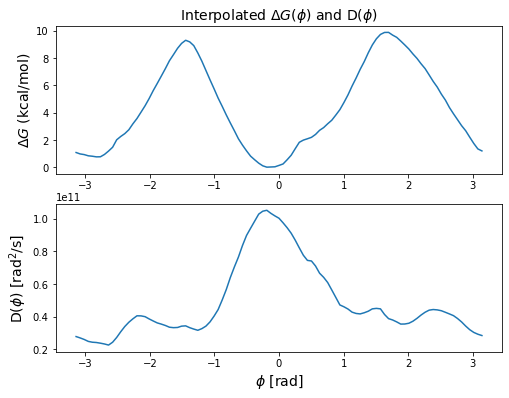

In [15]:
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(x_interp, G_interp)
plt.ylabel('$\Delta G$ (kcal/mol)', fontsize=14)
plt.title('Interpolated $\Delta G (\phi)$ and D($\phi$)', fontsize=14)
plt.subplot(212)
plt.plot(x_interp, D_interp)
plt.xlabel('$\phi$ [rad]', fontsize=14)
plt.ylabel(f'D($\phi$) [rad$^2$/s]', fontsize=14)

In [22]:
kB = 0.001987204118
T  = 300.0
kT = kB*T
b  = 1/kT

first_integrand = np.exp(b*G_interp)/D_interp
second_integrand = np.exp(-b*G_interp)

integral = []
for i in range(nbins):
    integral.append(np.trapz(second_integrand[:i], x=x_interp[:i]))
mfpt = cumtrapz(first_integrand*integral, x_interp, initial=0)
kphi = 1/mfpt[-1]

print(f'Mean first passage time : {mfpt[-1]:.2e} sec')
print(f'Rotational rate constant: {kphi:.2e} /sec')

Mean first passage time : 8.96e-05 sec
Rotational rate constant: 1.12e+04 /sec


Text(0, 0.5, 'MFPT (sec)')

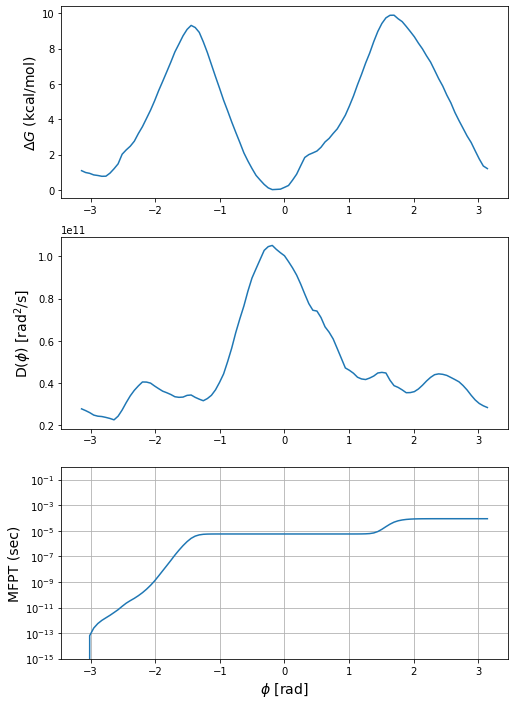

In [23]:
plt.figure(figsize=(8,12))
plt.subplot(311)
plt.plot(x_interp, G_interp)
plt.ylabel('$\Delta G$ (kcal/mol)', fontsize=14)
plt.subplot(312)
plt.plot(x_interp, D_interp)
plt.ylabel(f'D($\phi$) [rad$^2$/s]', fontsize=14)
plt.subplot(313)
plt.semilogy(x_interp,mfpt)
plt.ylim(1e-15,1)
plt.grid(True)
plt.xlabel('$\phi$ [rad]', fontsize=14)
plt.ylabel('MFPT (sec)', fontsize=14)